In [2]:
import pandas as pd
import numpy as np

data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, target)

In [4]:
import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense

def modelo():
    model = Sequential()

    model.add(Dense(20, input_dim=13, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))

    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [7]:
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [8]:
pipeline = []
pipeline.append(('standardize', StandardScaler()))
pipeline.append(('mlp', KerasRegressor(model=modelo, epochs=100, batch_size=5, verbose=0)))

pipeline = Pipeline(pipeline)
kfold = KFold(n_splits=10, random_state=7, shuffle = True)
results = cross_val_score(pipeline, X_train, y_train, cv=kfold)
print("Resultados: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Resultados: 0.83 (0.10) MSE


In [9]:
pipeline.fit(X_train, y_train)
y_hat = pipeline.predict(X_test)
pipeline.score(X_test, y_test)

0.829614519208456

In [10]:
from sklearn.metrics import r2_score

r2_score(y_hat, y_test)

0.8010785347911028

In [15]:
import pandas as pd
from pycebox.ice import ice, ice_plot

# pcyebox likes the data to be in a DataFrame so let's create one with our imputed data
# we first need to impute the missing data
feature_names=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
X_train_df = pd.DataFrame(X_train, columns=feature_names)

In [16]:
print(feature_names)

['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']


In [17]:
CRIM_ice_df = ice(data=X_train_df, column='CRIM', 
                   predict=pipeline.predict)

Text(0.5, 0, 'CRIME')

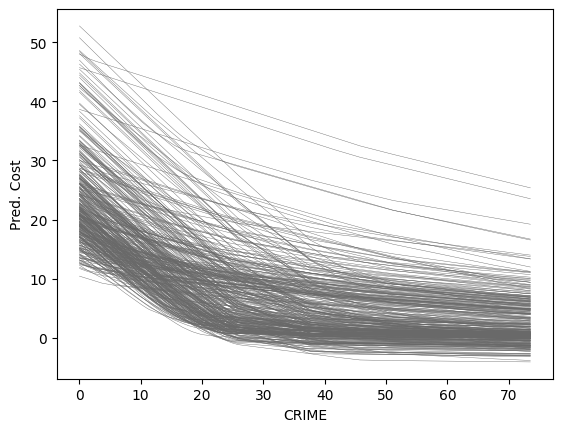

In [20]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

ice_plot(CRIM_ice_df, c='dimgray', linewidth=0.3)
plt.ylabel('Pred. Cost')
plt.xlabel('CRIME')

Text(0.5, 0, 'CRIME')

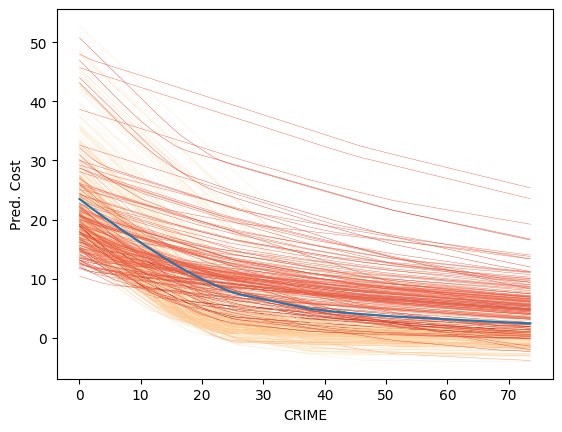

In [22]:
import warnings
warnings.filterwarnings('ignore')

# new colormap for ICE plot
cmap2 = plt.get_cmap('OrRd')

ice_plot(CRIM_ice_df, color_by='INDUS', linewidth=0.3, plot_pdp=True, cmap=cmap2)
plt.ylabel('Pred. Cost')
plt.xlabel('CRIME')

In [23]:
def plot_ice_grid(dict_of_ice_dfs, data_df, features, ax_ylabel='', nrows=3, 
                  ncols=3, figsize=(12, 12), sharex=False, sharey=True, 
                  subplots_kws={}, rug_kws={'color':'k'}, **ice_plot_kws):
    """A function that plots ICE plots for different features in a grid."""
    fig, axes = plt.subplots(nrows=nrows, 
                             ncols=ncols, 
                             figsize=figsize,
                             sharex=sharex,
                             sharey=sharey,
                             **subplots_kws)
    # for each feature plot the ice curves and add a rug at the bottom of the 
    # subplot
    for f, ax in zip(features, axes.flatten()):
        ice_plot(dict_of_ice_dfs[f], ax=ax, **ice_plot_kws)
        # add the rug
        sns.histplot(data_df[f], ax=ax, kde=True, stat="density", linewidth=0)
        sns.rugplot(data_df[f], ax=ax)
        ax.set(ylim=(0, 60))
        ax.set_title('feature = ' + f)
        ax.set_ylabel(ax_ylabel)
        sns.despine()
        
    # get rid of blank plots
    for i in range(len(features), nrows*ncols):
        axes.flatten()[i].axis('off')

    return fig

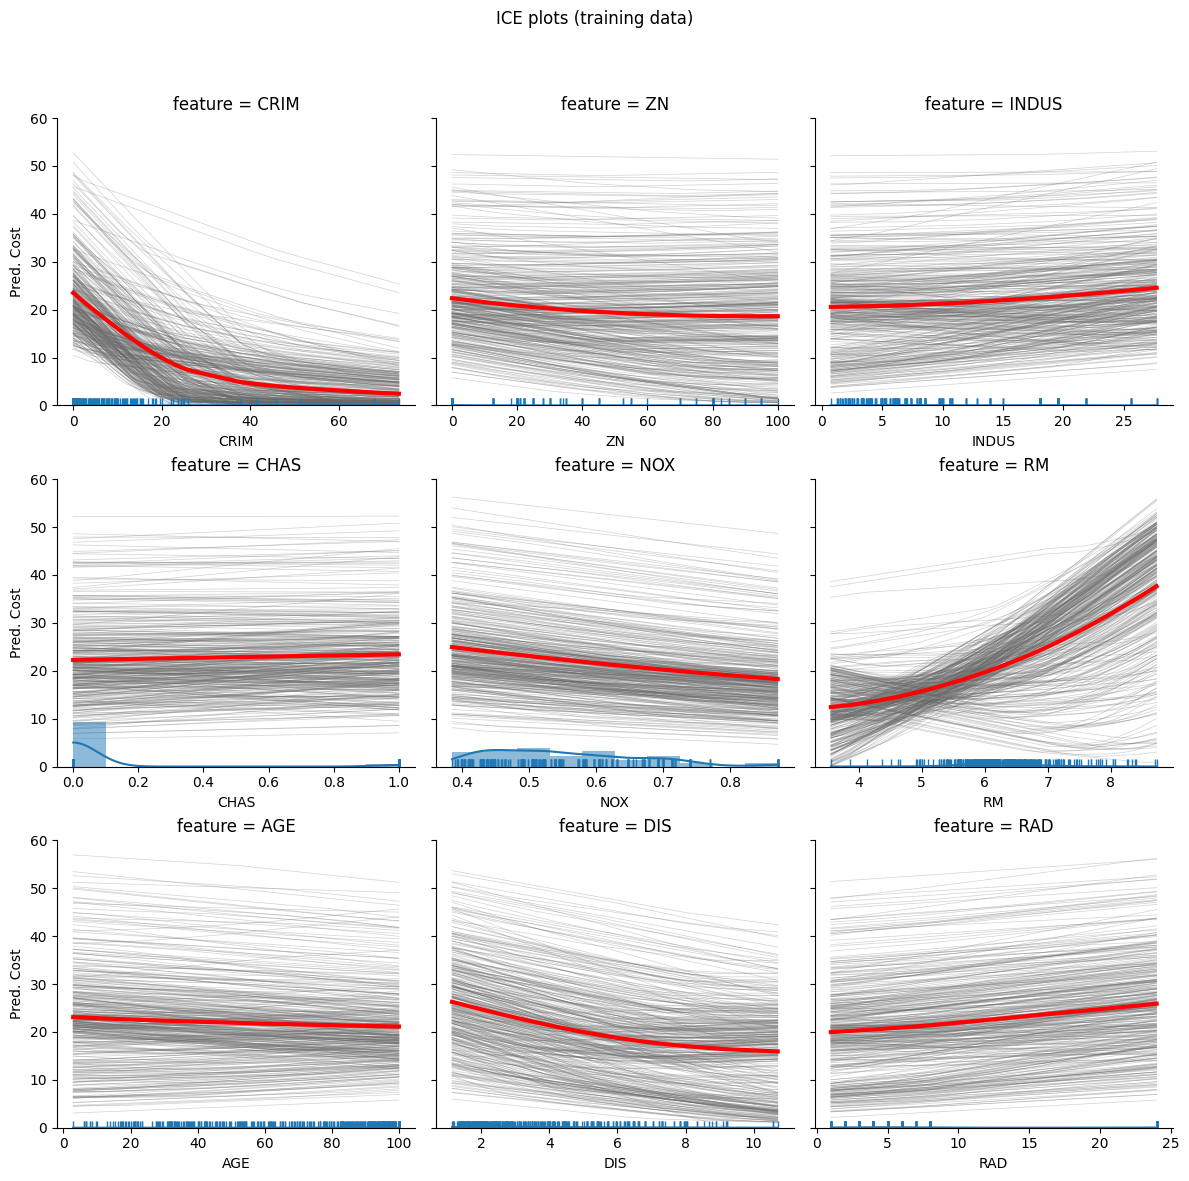

In [26]:
# create dict of ICE data for grid of ICE plots
train_ice_dfs = {feat: ice(data=X_train_df, column=feat, predict=pipeline.predict) 
                 for feat in feature_names}

fig = plot_ice_grid(train_ice_dfs, X_train_df, feature_names,
                    ax_ylabel='Pred. Cost', alpha=0.3, plot_pdp=True,
                    pdp_kwargs={'c': 'red', 'linewidth': 3},
                    linewidth=0.5, c='dimgray')
fig.tight_layout()
fig.suptitle('ICE plots (training data)')
fig.subplots_adjust(top=0.89);

In [29]:
import lime
from lime.lime_tabular import LimeTabularExplainer

In [30]:
# create the explainer by passing our training data, 
# setting the correct modeling mode, pass in feature names and
# make sure we don't discretize the continuous features
explainer = LimeTabularExplainer(X_train_df, mode='regression', 
                                 feature_names=feature_names, 
                                 random_state=7, 
                                 discretize_continuous=False) 

In [33]:
X_test_df = pd.DataFrame(X_test, columns=feature_names)
# the number of features to include in our predictions
num_features = len(feature_names)
# the index of the instance we want to explaine
exp_idx = 3
exp = explainer.explain_instance(X_test_df.iloc[exp_idx,:].values, 
                                 pipeline.predict, num_features=num_features)

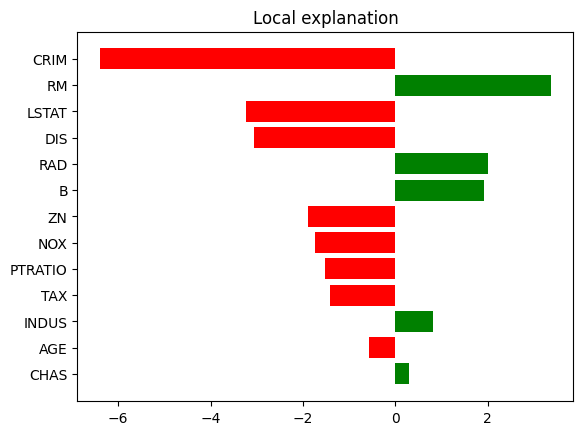

In [34]:
# a plot of the weights for each feature
exp.as_pyplot_figure();